## <center> Advanced Classification </center>

In this notebook a combination of continuous and categorical data will be used to perform a classification. The goal is to estimate the cost of a New York City cab ride from several inputs. The inspiration behind this code along is a recent <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a>.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

### Exploarory data analysis

#### Load the NYC Taxi Fares dataset
The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. It is up to the contest participant to extract any further information. For instance, does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

For this exercise we've whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. The records are randomly sorted. We'll show how to calculate distance from GPS coordinates, and how to create a pandas datatime object from a text column. This will let us quickly get information like day of the week, am vs. pm, etc.

In [2]:
df = pd.read_csv("C:/Users/Lenovo/Desktop/Python/Deep Learning/Data Sets/PyTorch/NYCTaxiFares.csv")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_class'].value_counts()

0    80000
1    40000
Name: fare_class, dtype: int64

Conveniently, 2/3 of the data have fares under $10, and 1/3 have fares $10 and above.
Fare classes correspond to fare amounts as follows:
<table style="display: inline-block">
<tr><th>Class</th><th>Values</th></tr>
<tr><td>0</td><td>< \$10.00</td></tr>
<tr><td>1</td><td>>= \$10.00</td></tr>
</table>

#### Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$r: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2: \textrm {longitudes of point 1 and point 2}$

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d


df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')


#### Add a datetime column and derive useful statistics
By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc.
Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [5]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4) # There is a 4 hours difference between data and actual travel
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour'] < 12,'AM','PM')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

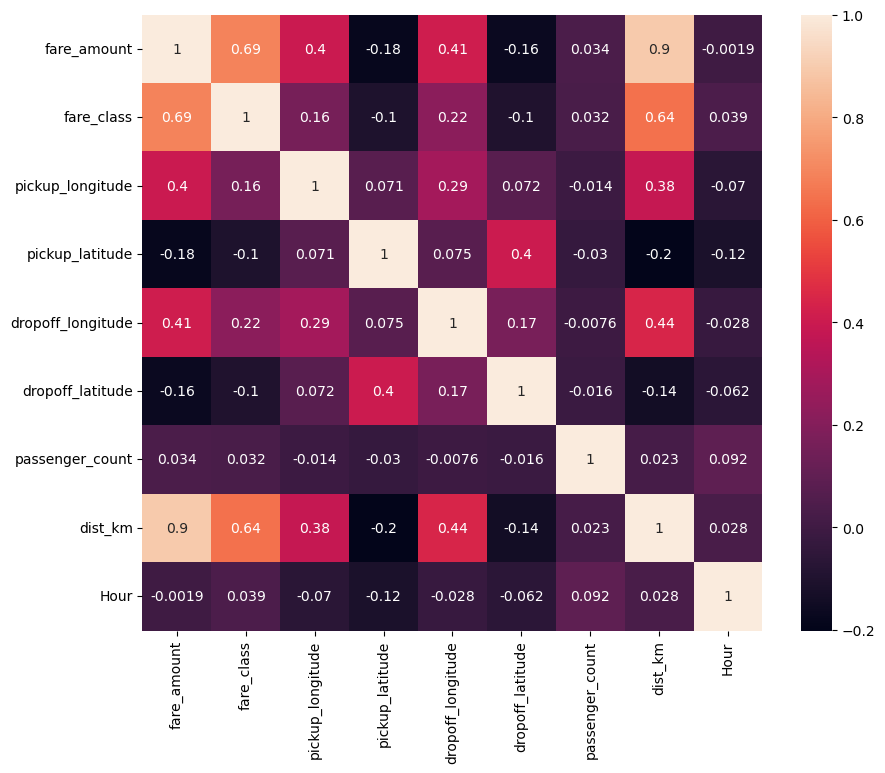

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

### Model
The implemented model demonstrates the capability to seamlessly handle both categorical and continuous variables. Leveraging this versatility, the data loader intelligently dissects the input data into distinct categories of categorical and continuous variables. Additionally, it dynamically calculates the embedding size, ensuring optimal utilization of resources and efficient representation of categorical data. This innovative approach empowers the model to efficiently process diverse types of input features, enhancing its flexibility and adaptability across various real-world scenarios.

#### Data Loader

In [7]:
class CustomDataLoader:
    def __init__(self, data, target, cat_cols=None, cont_cols=None, val_size=0.2, test_size=0.2, batch_size=2048):  
        self.batch_size = batch_size
        
        # Preprocess categorical variables 
        cats = []
        for cat in cat_cols:
            data[cat] = data[cat].astype('category')
            vec = data[cat].cat.codes.values
            cats.append(vec)
        cats = np.stack(cats, 1)
        
        cat_szs = [len(data[col].cat.categories) for col in cat_cols]
        self.emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
        
        # Preprocess continuous variables
        conts = []
        for con in cont_cols:
            vec = data[con].values
            conts.append(vec)
        conts = np.stack(conts, 1)

        # Concatenate categorical and continuous variables
        X = np.hstack((cats, conts))
        
        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, target.values, test_size=test_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=42)

        # Separate categorical and continuous variables
        self.cat_train, self.cat_val, self.cat_test = X_train[:, :cats.shape[1]], X_val[:, :cats.shape[1]], X_test[:, :cats.shape[1]]
        self.cont_train, self.cont_val, self.cont_test = X_train[:, cats.shape[1]:], X_val[:, cats.shape[1]:], X_test[:, cats.shape[1]:]
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

    def get_data_loaders(self):
        # Combine categorical and continuous features with target into one TensorDataset
        train_dataset = TensorDataset(
            torch.tensor(self.cat_train, dtype=torch.long), 
            torch.tensor(self.cont_train, dtype=torch.float32),
            torch.tensor(self.y_train, dtype=torch.long))
        val_dataset = TensorDataset(
            torch.tensor(self.cat_val, dtype=torch.long), 
            torch.tensor(self.cont_val, dtype=torch.float32),
            torch.tensor(self.y_val, dtype=torch.long))
        test_dataset = TensorDataset(
            torch.tensor(self.cat_test, dtype=torch.long), 
            torch.tensor(self.cont_test, dtype=torch.float32),
            torch.tensor(self.y_test, dtype=torch.long))

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader


X = df.drop(columns=["fare_class"])
y = df["fare_class"]
cat_cols = ['Hour', 'AMorPM', 'Weekday'] # Despite of Hour being numeric, it is counted as categorical
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
custom_loader = CustomDataLoader(X, y, cat_cols, cont_cols)
train_loader, val_loader, test_loader = custom_loader.get_data_loaders()

#### Neural Network 

In [8]:
class Model(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        y_pred = F.log_softmax(x, dim=1)
        return y_pred



# Define input and output sizes
model = Model(custom_loader.emb_szs, len(cont_cols), y.nunique(), [200, 100], p=0.4) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

### Training

Epoch 1/50, Train Loss: 0.7676, Test Loss: 0.6273
Epoch 2/50, Train Loss: 0.4817, Test Loss: 0.4130
Epoch 3/50, Train Loss: 0.3824, Test Loss: 0.3524
Epoch 4/50, Train Loss: 0.3372, Test Loss: 0.3193
Epoch 5/50, Train Loss: 0.3114, Test Loss: 0.3009
Epoch 6/50, Train Loss: 0.2963, Test Loss: 0.2899
Epoch 7/50, Train Loss: 0.2877, Test Loss: 0.2840
Epoch 8/50, Train Loss: 0.2826, Test Loss: 0.2805
Epoch 9/50, Train Loss: 0.2802, Test Loss: 0.2786
Epoch 10/50, Train Loss: 0.2783, Test Loss: 0.2774
Epoch 11/50, Train Loss: 0.2767, Test Loss: 0.2774
Epoch 12/50, Train Loss: 0.2763, Test Loss: 0.2757
Epoch 13/50, Train Loss: 0.2753, Test Loss: 0.2753
Epoch 14/50, Train Loss: 0.2743, Test Loss: 0.2747
Epoch 15/50, Train Loss: 0.2738, Test Loss: 0.2745
Epoch 16/50, Train Loss: 0.2732, Test Loss: 0.2743
Epoch 17/50, Train Loss: 0.2729, Test Loss: 0.2741
Epoch 18/50, Train Loss: 0.2733, Test Loss: 0.2756
Epoch 19/50, Train Loss: 0.2725, Test Loss: 0.2731
Epoch 20/50, Train Loss: 0.2723, Test Lo

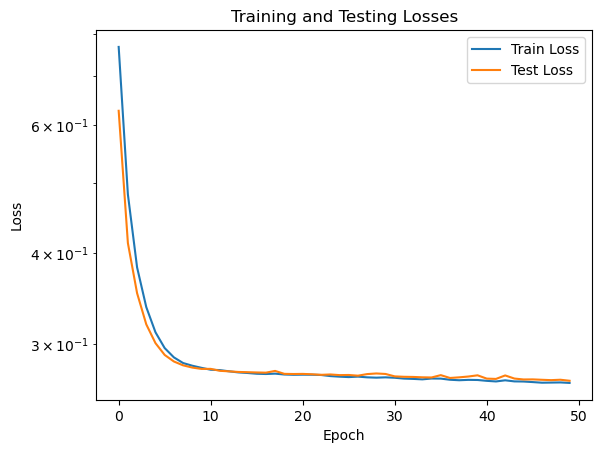

[[920  98]
 [ 53 401]]


In [9]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def train(self, max_epochs):
        self.train_losses = []
        self.val_losses = []

        # Training
        for epoch in range(max_epochs):
            self.model.train
            train_loss = 0

            for cat_inputs, cont_inputs, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(cat_inputs, cont_inputs)
                loss = self.criterion(outputs.squeeze(), labels)  # Assuming output shape is [batch_size, 1]
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * cat_inputs.size(0)
            train_loss /= len(self.train_loader.dataset)
            self.train_losses.append(train_loss)

            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for cat_inputs, cont_inputs, labels in self.val_loader:
                    outputs = self.model(cat_inputs, cont_inputs)
                    loss = self.criterion(outputs.squeeze(), labels)
                    val_loss += loss.item() * cat_inputs.size(0)
                val_loss /= len(self.val_loader.dataset)
            self.val_losses.append(val_loss)

            if epoch % 1 == 0:
                print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}')
 
        return self.model
    
    def plot_losses(self, train_losses, test_losses):
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Set y-axis scale to logarithmic
        plt.title('Training and Testing Losses')
        plt.legend()
        plt.show()
    
    def evaluation(self, model, test_loader):
        model.eval()
        with torch.no_grad():
            for cat_inputs, cont_inputs, labels in test_loader:
                outputs = model(cat_inputs, cont_inputs)
                outputs = torch.max(outputs.squeeze(),1)[1]
        print(confusion_matrix(outputs.view(-1), labels.view(-1)))
            

trainer = Trainer(model, optimizer, criterion, train_loader, val_loader)   
model = trainer.train(50)      
trainer.plot_losses(trainer.train_losses, trainer.val_losses)
trainer.evaluation(model, test_loader)